In [ ]:
!pip install kwant

     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Created wheel for kwant: filename=kwant-1.4.3-cp37-cp37m-linux_x86_64.whl size=3691018 sha256=8896bbdf1f9a259d639769c35203835063ecb45951c0842773dd70bcce93bcc5
  Stored in directory: /root/.cache/pip/wheels/d6/2d/93/6f395cd3f0798d7d9e161dce1c8b8c8bbd04d4547763c926de
  Created wheel for tinyarray: filename=tinyarray-1.2.4-cp37-cp37m-linux_x86_64.whl size=228000 sha256=33bc3180624b21951a842225f1c925d8ff912d6805ecb127f4c30d219bbde804
  Stored in directory: /root/.cache/pip/wheels/85/c6/1c/6939e2931cfbff5df75758a06084bf67171b640ebdf5febd35
Successfully built kwant tinyarray


In [ ]:
import kwant
from matplotlib import pyplot as plt
import tinyarray as ta
import numpy as np
import scipy.sparse.linalg as sla
import scipy

/usr/local/lib/python3.7/dist-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


This is a tutorial for SSH model 2 atoms in cell

[-1.49995915  1.49995915]


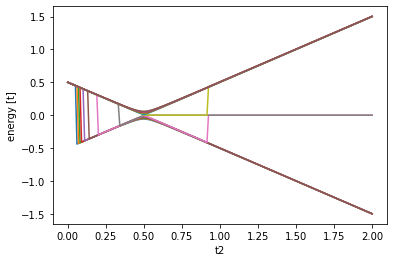

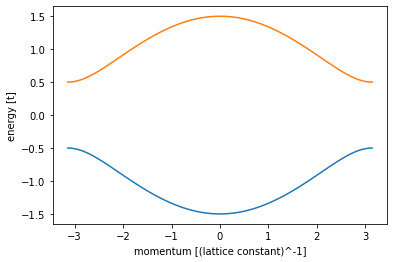

In [ ]:
def ssh_model(t_1=1.0, t_2=0.5):
    L=200
    a=1
    # Start with an empty tight-binding system and a single square lattice.
    # `a` is the lattice constant (by default set to 1 for simplicity.
    syst = kwant.Builder()
    
    lat = kwant.lattice.Polyatomic([[2*a, 0]], [[0, 0], [a, 0]])
    lat.a, lat.b = lat.sublattices
    
    for n in range(L):
        syst[lat.a(n)] = 0
        syst[lat.b(n)] = 0
    
    # Left hopping
    for n in range(L):
        syst[lat.a(n), lat.b(n)] = t_1
        
    # Left hopping
    for n in range(1,L):
        syst[lat.b(n-1), lat.a(n)] = t_2
        
    leadless=syst
    leadless=leadless.finalized()
    leadless=leadless.hamiltonian_submatrix(sparse=True)


    sym_left_lead = kwant.TranslationalSymmetry([-2*a, 0])
    left_lead = kwant.Builder(sym_left_lead)
    left_lead[lat.a(0)] = 0
    left_lead[lat.b(0)] = 0
    left_lead[lat.a(0), lat.b(0)] = t_1
    left_lead[lat.b(0), lat.a(-1)] = t_2
    syst.attach_lead(left_lead)
    left_lead_fin = left_lead.finalized()

    sym_right_lead = kwant.TranslationalSymmetry([2*a, 0])
    right_lead = kwant.Builder(sym_right_lead)
    right_lead[lat.a(0)] = 0
    right_lead[lat.b(0)] = 0
    right_lead[lat.a(0), lat.b(0)] = t_1
    right_lead[lat.a(0), lat.a(1)] = t_2
    syst.attach_lead(right_lead)
    right_lead_fin = right_lead.finalized()
           
    syst = syst.finalized()
    return syst, left_lead_fin, right_lead_fin,leadless

syst, left_lead, right_lead, leadless= ssh_model()
kwant.plot(syst, file='ssh_2_atoms_in_cell.pdf')
def compute_evs(sys):
    # Compute some eigenvalues of the closed system
    sparse_mat = sys.hamiltonian_submatrix(sparse=True)

    evs = sla.eigs(sparse_mat, 2)[0]
    print(evs.real)

def plot_eigen_energy():
    k_tab = np.linspace(0, 2, 200)
    energies = []
    for t2 in k_tab:
        ham = ssh_model(0.5, t2)
        e_val, e_vec = scipy.sparse.linalg.eigsh(ham[3], k=16,sigma=0.001,which='LM', return_eigenvectors=True)
        e_val = np.sort(e_val)
        energies.append(e_val)
        
    plt.figure()
    plt.plot(k_tab, energies)
    plt.xlabel("t2")
    plt.ylabel("energy [t]")
    
def plot_bandstructure(flead, momenta):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]

    plt.figure()
    plt.plot(momenta, energies)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    plt.savefig('ssh_energy_bands.pdf')
    plt.show()

plot_eigen_energy()
compute_evs(syst)  
plot_bandstructure(left_lead, np.linspace(-np.pi, np.pi, 100))
#syst.hamiltonian_submatrix()